In [56]:
! pip3 install transformers torch einops fancy_einsum wandb plotly torchinfo tqdm --quiet

In [57]:
! pip install 'protobuf<=3.18'

In [58]:
import hashlib
import os
import sys
import zipfile
import torch as t
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import transformers
from einops import rearrange
from torch.nn import functional as F
from tqdm import tqdm
import requests
import utils
from dataclasses import dataclass
from typing import List, Tuple
import wandb

MAIN = __name__ == "__main__"
DATA_FOLDER = "./data"
DATASET = "2"
BASE_URL = "https://s3.amazonaws.com/research.metamind.io/wikitext/"
DATASETS = {"103": "wikitext-103-raw-v1.zip", "2": "wikitext-2-raw-v1.zip"}
TOKENS_FILENAME = os.path.join(DATA_FOLDER, f"wikitext_tokens_{DATASET}.pt")

if not os.path.exists(DATA_FOLDER):
    os.mkdir(DATA_FOLDER)


In [59]:
def maybe_download(url: str, path: str) -> None:
    '''
    Download the file from url and save it to path. 
    If path already exists, do nothing.
    '''
    if not os.path.exists(path):
        print(f"Downloading {url} to {path}")
        with open(path, "wb") as f:
            f.write(requests.get(url).content)


In [60]:
path = os.path.join(DATA_FOLDER, DATASETS[DATASET])
maybe_download(BASE_URL + DATASETS[DATASET], path)
expected_hexdigest = {"103": "0ca3512bd7a238be4a63ce7b434f8935", "2": "f407a2d53283fc4a49bcff21bc5f3770"}
with open(path, "rb") as f:
    actual_hexdigest = hashlib.md5(f.read()).hexdigest()
    assert actual_hexdigest == expected_hexdigest[DATASET]

print(f"Using dataset WikiText-{DATASET} - options are 2 and 103")
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")

z = zipfile.ZipFile(path)

def decompress(*splits: str) -> str:
    return [
        z.read(f"wikitext-{DATASET}-raw/wiki.{split}.raw").decode("utf-8").splitlines()
        for split in splits
    ]

train_text, val_text, test_text = decompress("train", "valid", "test")

Using dataset WikiText-2 - options are 2 and 103


In [61]:
#@title Transformer Modules
@dataclass(frozen=True)
class TransformerConfig:
    '''Constants used throughout your decoder-only transformer model.'''

    num_layers: int
    num_heads: int
    vocab_size: int
    hidden_size: int # also embedding dim or d_model
    max_seq_len: int = 5000 
    dropout: float = 0.1
    layer_norm_epsilon: float = 1e-05
    device = t.device('cuda' if t.cuda.is_available() else 'cpu')

In [62]:
# Call the tokenizer on the list of lines with truncation=False to obtain lists of tokens. 
# These will be of varying length, and you'll notice some are empty due to blank lines.

# Build one large 1D tensor containing all the tokens in sequence
# Reshape the 1D tensor into (batch, sequence).

def tokenize_1d(tokenizer, lines: List[str], max_seq: int) -> t.Tensor:
    '''Tokenize text and rearrange into chunks of the maximum length.

    Return (batch, seq) and an integer dtype.
    '''
    tokens = map(tokenizer.encode, lines) # tokenize
    flattened = (item for sublist in tokens for item in sublist) # flatten
    ten = t.tensor(list(flattened), dtype=t.int) # convert to tensor
    ten = ten[: max_seq * (ten.shape[0] // max_seq)] # truncate to max_seq
    return ten.reshape(-1, max_seq) # reshape to (batch, seq)

if False:
    max_seq = 128
    print("Tokenizing training text...")
    train_data = tokenize_1d(tokenizer, train_text, max_seq)
    print("Training data shape is: ", train_data.shape)
    print("Tokenizing validation text...")
    val_data = tokenize_1d(tokenizer, val_text, max_seq)
    print("Tokenizing test text...")
    test_data = tokenize_1d(tokenizer, test_text, max_seq)
    print("Saving tokens to: ", TOKENS_FILENAME)
    t.save((train_data, val_data, test_data), TOKENS_FILENAME)

In [63]:
def random_mask(
    input_ids: t.Tensor, mask_token_id: int, vocab_size: int, select_frac=0.15, mask_frac=0.8, random_frac=0.1
) -> Tuple[t.Tensor, t.Tensor]:
    '''Given a batch of tokens, return a copy with tokens replaced according to Section 3.1 of the paper.

    input_ids: (batch, seq)

    Return: (model_input, was_selected) where:

    model_input: (batch, seq) - a new Tensor with the replacements made, suitable for passing to the BertLanguageModel. Don't modify the original tensor!

    was_selected: (batch, seq) - 1 if the token at this index will contribute to the MLM loss, 0 otherwise


    we must mask 15% of tokens in each sequence
    80% of those must be replaced with the [MASK] token
    The remaining 10% of masked tokens can be replaced with any token from the vocabulary.
    '''
    device = input_ids.device
    d_batch, d_seq = input_ids.shape
    n_masking = select_frac * d_seq * d_batch
    n_mask = int(n_masking * mask_frac)
    n_random = int(n_masking * random_frac)
    n_unchanged = int(n_masking * (1 - mask_frac - random_frac))
    # print(f'Out of {d_seq}, masking {n_mask} tokens with [MASK], {n_random} with random tokens, and {n_unchanged} unchanged')
    # print(f'Frequency of [MASK] is {n_mask / d_seq}')
    # print(f'Frequency of random is {n_random / d_seq}')
    # print(f'Frequency of unchanged is {n_unchanged / d_seq}')
    # choose which tokens to mask
    mask = t.zeros(d_batch*d_seq, dtype=t.int, device=device)
    mask[:n_mask] = 1
    mask[n_mask:n_mask + n_random] = 2
    mask[n_mask + n_random:n_mask + n_random + n_unchanged] = 3
    mask = mask.reshape(d_batch, d_seq)
    
    # for the input ids replace them with masked token where mask = 1
    # and with random token where mask = 2
    model_input = input_ids.clone()
    model_input[mask == 1] = mask_token_id
    rand = t.randint(0, vocab_size, (d_batch, d_seq), device=device)
    model_input = t.where(mask == 2, rand, model_input)
    mask = t.where(mask != 0, 1, 0)

    return model_input, mask
    
# test mask

# print decoded tokens
# print(tokenizer.decode(train_data[:2].flatten().tolist()))
out1, mask1 = random_mask(train_data[:2], tokenizer.mask_token_id, tokenizer.vocab_size, select_frac=0.85, mask_frac=0.1, random_frac=0.8)
# print(tokenizer.decode(out1.flatten().tolist()))


if MAIN:
    utils.test_random_mask(random_mask, input_size=10000, max_seq=max_seq)

Testing empirical frequencies
Checking fraction of tokens selected...
Checking fraction of tokens masked...
Checking fraction of tokens masked OR randomized...


In [64]:
# Find the word frequencies
word_frequencies = t.bincount(train_data.flatten())
# Drop the words with occurrence zero (because these contribute zero to cross entropy)
word_frequencies = word_frequencies[word_frequencies > 0]
# Get probabilities
word_probabilities = word_frequencies / word_frequencies.sum()
# Calculate the cross entropy
cross_entropy = (- word_probabilities * word_probabilities.log()).sum()
print(cross_entropy)
# ==> 7.3446

tensor(7.2800)


In [65]:
def flat(x: t.Tensor) -> t.Tensor:
    """Combines batch and sequence dimensions."""
    return rearrange(x, "b s ... -> (b s) ...")

def cross_entropy_selected(pred: t.Tensor, target: t.Tensor, was_selected: t.Tensor) -> t.Tensor:
    '''
    pred: (batch, seq, vocab_size) - predictions from the model
    target: (batch, seq, ) - the original (not masked) input ids
    was_selected: (batch, seq) - 1 if the token at this index will contribute to the MLM loss, 0 otherwise

    Out: the mean loss per predicted token
    '''
    # select correct predictions from the predictions
    target = t.where(was_selected == 1, target, -100)
    entropy = F.cross_entropy(flat(pred), flat(target.long()))
    return entropy


if MAIN:
    utils.test_cross_entropy_selected(cross_entropy_selected)

    batch_size = 8
    seq_length = 512
    batch = t.randint(0, tokenizer.vocab_size, (batch_size, seq_length))
    pred = t.rand((batch_size, seq_length, tokenizer.vocab_size))
    (masked, was_selected) = random_mask(batch, tokenizer.mask_token_id, tokenizer.vocab_size)
    loss = cross_entropy_selected(pred, batch, was_selected).item()
    print(f"Random MLM loss on random tokens - does this make sense? {loss:.2f}")

Random MLM loss on random tokens - does this make sense? 10.32


In [66]:
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")

hidden_size = 512
bert_config_tiny = TransformerConfig(
    num_layers = 8,
    num_heads = hidden_size // 64,
    vocab_size = 28996,
    hidden_size = hidden_size,
    max_seq_len = 128,
    dropout = 0.1,
    layer_norm_epsilon = 1e-12
)

config_dict = dict(
    lr=0.0002,
    epochs=40,
    batch_size=128,
    weight_decay=0.01,
    mask_token_id=tokenizer.mask_token_id,
    warmup_step_frac=0.01,
    eps=1e-06,
    max_grad_norm=None,
)

(train_data, val_data, test_data) = t.load("./data/wikitext_tokens_2.pt")
print("Training data size: ", train_data.shape)

train_loader = DataLoader(
    TensorDataset(train_data), shuffle=True, batch_size=config_dict["batch_size"], drop_last=True
)

Training data size:  torch.Size([19159, 128])


# BERT

In [67]:
import torch as t
import torch.nn as nn
from einops import rearrange, repeat
from fancy_einsum import einsum
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
from dataclasses import dataclass 
from collections import OrderedDict
import math
from typing import Optional, Union
import plotly.express as px
import torchinfo
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm_notebook
import transformers
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import utils

device = t.device('cuda' if t.cuda.is_available() else 'cpu')

bertconfig = TransformerConfig(
    num_layers = 12,
    num_heads = 12,
    vocab_size = 28996,
    hidden_size = 768,
    max_seq_len = 512,
    dropout = 0.1,
    layer_norm_epsilon = 1e-12
)
class MultiLayerPerceptron(nn.Module):  

    def __init__(self, d_in: int, d_out: int):
        super().__init__()
        d_h = d_in * 4
        self.model = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(d_in, d_h)),
            ('GELU', nn.GELU()),
            ('linear2', nn.Linear(d_h, d_in)),   
            ('dropout', nn.Dropout(p=0.1))
        ]))

    def forward(self, x: t.Tensor):
        return self.model(x)

class MultiheadMaskedAttention(nn.Module):

    def __init__(self, hidden_size: int, num_heads: int):
        super().__init__()
        self.W_QKV = nn.Linear(hidden_size, hidden_size * 3)
        self.W_O = nn.Linear(hidden_size, hidden_size)
        self.num_heads = num_heads
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.1)

    def forward(self, x: t.Tensor, mask=None) -> t.Tensor:
        '''
        x: shape (batch, seq, hidden_size)
        Return: shape (batch, seq, hidden_size)
        '''
        Q, K, V = self.W_QKV(x).chunk(3, dim=-1)
        att = self.multihead_masked_attention(Q, K, V, self.num_heads)
        return self.W_O(att)

    def multihead_masked_attention(self, Q: t.Tensor, K: t.Tensor, V: t.Tensor, n_heads: int):
        '''
        Q: shape (b, s1, e)
        K: shape (b, s2, e)
        V: shape (b, s2, e)

        e = nheads * h
        b = batch
        s = seq_len
        h = hidden

        Return: shape (b s e)
        '''

        assert Q.shape[-1] % n_heads == 0
        assert K.shape[-1] % n_heads == 0
        assert V.shape[-1] % n_heads == 0
        assert K.shape[-1] == V.shape[-1]

        Q = rearrange(Q, 'b s (nheads h) -> b nheads s h', nheads=n_heads)
        K = rearrange(K, 'b s (nheads h) -> b nheads s h', nheads=n_heads)
        V = rearrange(V, 'b s (nheads h) -> b nheads s h', nheads=n_heads)

        batch, nheads, seq_len, headsize = Q.shape

        scaled_dot_prod = einsum('b nheads s1 h, b nheads s2 h -> b nheads s2 s1', K, Q) / (headsize ** 0.5)
        mask_filter = t.triu(t.full_like(scaled_dot_prod, -t.inf), 1)
        scaled_dot_prod += mask_filter
        attention_probs = scaled_dot_prod.softmax(dim=-1)
        attention_probs = self.dropout1(attention_probs)
        attention_vals = einsum('b nheads s1 s2, b nheads s2 c -> b nheads s1 c', attention_probs, V)
        attention = rearrange(attention_vals, 'b nheads s c -> b s (nheads c)')
        return self.dropout2(attention) 

class GPT2DecoderBlock(nn.Module):

    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.layernorm1 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiheadMaskedAttention(
            hidden_size=config.hidden_size,
            num_heads=config.num_heads
        )
        self.layernorm2 = nn.LayerNorm(config.hidden_size)
        self.mlp = MultiLayerPerceptron(config.hidden_size, config.hidden_size)
    
    def forward(self, x: t.Tensor):
        x = x + self.attention(self.layernorm1(x))
        x = x + self.mlp(self.layernorm2(x))
        return x

class GPT2(nn.Module):

    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.embed = nn.Embedding(config.vocab_size, config.hidden_size)
        self.positional_encoding = nn.Embedding(config.max_seq_len, config.hidden_size)
        decoders = [GPT2DecoderBlock(config) for i in range(config.num_layers)]
        names = ['decoder' + str(i) for i in range(config.num_layers)]
        self.decoderlayer = nn.Sequential(OrderedDict(zip(names, decoders)))
        self.dropout = nn.Dropout(p=config.dropout)
        self.layernorm = nn.LayerNorm(config.hidden_size)

    def forward(self, tokens):
        if len(tokens.shape) == 1:
            tokens = rearrange(tokens, "seq -> 1 seq")
        embedding = self.embed(tokens) # (b, seq_len) -> (b, seq_len, embedding)
        pos_enc = self.positional_encoding(t.arange(tokens.shape[1], device=tokens.device)) # (seq_len)
        a = self.dropout(embedding + pos_enc) # (b, seq_len, embedding)
        b = self.decoderlayer(a) # (b, seq_len, embedding)
        c = self.layernorm(b) @ self.embed.weight.T # (b, seq_len, embedding) @ (embedding, vocab_size) -> (b, seq_len, vocab_size)
        return c

class MultiheadAttention(nn.Module):

    def __init__(self, config: TransformerConfig):
        super().__init__()
        hidden_size, num_heads = config.hidden_size, config.num_heads
        self.num_heads = num_heads
        self.W_Q = nn.Linear(hidden_size, hidden_size)
        self.W_K = nn.Linear(hidden_size, hidden_size)
        self.W_V = nn.Linear(hidden_size, hidden_size)
        self.W_O = nn.Linear(hidden_size, hidden_size)
        self.num_heads = num_heads

    def forward(self, x: t.Tensor, additive_attention_mask: Optional[t.Tensor] = None) -> t.Tensor:
        Q, K, V = self.W_Q(x), self.W_K(x), self.W_V(x)
        att = self.multihead_masked_attention(Q, K, V, self.num_heads, additive_attention_mask)
        return self.W_O(att)

    def multihead_masked_attention(self, Q: t.Tensor, K: t.Tensor, V: t.Tensor, n_heads: int, additive_attention_mask: Optional[t.Tensor]):
        '''
        Q: shape (b, s1, e)
        K: shape (b, s2, e)
        V: shape (b, s2, e)

        e = nheads * h
        b = batch
        s = seq_len
        h = hidden

        Return: shape (b s e)
        '''

        assert Q.shape[-1] % n_heads == 0
        assert K.shape[-1] % n_heads == 0
        assert V.shape[-1] % n_heads == 0
        assert K.shape[-1] == V.shape[-1]

        Q = rearrange(Q, 'b s (nheads h) -> b nheads s h', nheads=n_heads)
        K = rearrange(K, 'b s (nheads h) -> b nheads s h', nheads=n_heads)
        V = rearrange(V, 'b s (nheads h) -> b nheads s h', nheads=n_heads)

        batch, nheads, seq_len, headsize = Q.shape

        scaled_dot_prod = einsum('b nheads sk h, b nheads sq h -> b nheads sq sk', K, Q) / (headsize ** 0.5)
        if additive_attention_mask is not None:
            scaled_dot_prod += additive_attention_mask # (batch, 1, 1, sk)
        attention_probs = scaled_dot_prod.softmax(dim=-1)
        attention_vals = einsum('b nheads s1 s2, b nheads s2 c -> b nheads s1 c', attention_probs, V)
        attention = rearrange(attention_vals, 'b nheads s c -> b s (nheads c)')
        return attention

class BERTMLP(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()
        hs, p_dropout = config.hidden_size, config.dropout
        self.mlp = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(hs, hs * 4)),
            ('GELU', nn.GELU()),
            ('linear2', nn.Linear(hs * 4, hs)),   
            ('dropout', nn.Dropout(p_dropout))
        ]))

    def forward(self, x: t.Tensor):
        return self.mlp(x)

class BERTBlock(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.attention = MultiheadAttention(config)
        self.ln1 = nn.LayerNorm(config.hidden_size)
        self.mlp = BERTMLP(config)
        self.ln2 = nn.LayerNorm(config.hidden_size)
        
    def forward(self, x: t.Tensor, additive_attention_mask: Optional[t.Tensor] = None) -> t.Tensor:
        '''
        x: shape (batch, seq, hidden_size)
        additive_attention_mask: shape (batch, nheads=1, seqQ=1, seqK)
        '''
        h1 = self.ln1(self.attention(x, additive_attention_mask) + x) # TODO chain this
        h2 = self.ln2(self.mlp(h1) + h1)
        return h2

def make_additive_attention_mask(one_zero_attention_mask: t.Tensor, big_negative_number: float = -10000) -> t.Tensor:
    '''
    one_zero_attention_mask: 
        shape (batch, seq)
        Contains 1 if this is a valid token and 0 if it is a padding token.

    big_negative_number:
        Any negative number large enough in magnitude that exp(big_negative_number) is 0.0 for the floating point precision used.

    Out: 
        shape (batch, nheads=1, seqQ=1, seqK)
        Contains 0 if attention is allowed, big_negative_number if not.
    '''
    return rearrange((1 - one_zero_attention_mask) * big_negative_number, 'batch seq -> batch 1 1 seq')

# util one is erroring
def test_make_additive_attention_mask(make_additive_attention_mask):
    def make_additive_attention_mask_soln(one_zero_attention_mask: t.Tensor, big_negative_number: float = -10000) -> t.Tensor:
        '''
        one_zero_attention_mask: 
            shape (batch, seq)
            Contains 1 if this is a valid token and 0 if it is a padding token.

        big_negative_number:
            Any negative number large enough in magnitude that exp(big_negative_number) is 0.0 for the floating point precision used.

        Out: shape (batch, heads, seq, seq). Contains 0 if attention is allowed, and big_negative_number if it is not allowed.
        '''
        return big_negative_number * repeat(1 - one_zero_attention_mask, "batch seqK -> batch 1 1 seqK")
    arr = t.randint(low=0, high=2, size=(3, 4))
    expected = make_additive_attention_mask_soln(arr)
    actual = make_additive_attention_mask(arr)
    t.testing.assert_close(expected, actual)

class BertCommon(nn.Module):

    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
        self.pos_emb = nn.Embedding(config.max_seq_len, config.hidden_size)
        self.tokentype_emb = nn.Embedding(2, config.hidden_size)
        self.ln1 = nn.LayerNorm(config.hidden_size)
        self.dropout1 = nn.Dropout(config.dropout)
        self.bertblocks = nn.ModuleList([BERTBlock(config) for i in range(config.num_layers)])

    def forward(
        self,
        input_ids: t.Tensor,
        one_zero_attention_mask: Optional[t.Tensor] = None,
        token_type_ids: Optional[t.Tensor] = None,
    ) -> t.Tensor:
        '''
        input_ids: (batch, seq) - the token ids
        one_zero_attention_mask: (batch, seq) - only used in training, passed to `make_additive_attention_mask` and used in the attention blocks.
        token_type_ids: (batch, seq) - only used for NSP, passed to token type embedding.
        '''
        token_embedding = self.token_emb(input_ids) # (b, seq_len, emb)
        batch, seq_len = input_ids.shape
        positional_embedding = self.pos_emb(t.arange(seq_len, device=input_ids.device)) # (seq_len, emb)
        token_type_ids = token_type_ids if token_type_ids else t.zeros_like(input_ids)
        token_type_embedding = self.tokentype_emb(token_type_ids) # (b, seq_len, emb)
        x = self.dropout1(self.ln1(token_embedding + positional_embedding + token_type_embedding))
        mask = make_additive_attention_mask(one_zero_attention_mask) if one_zero_attention_mask is not None else None
        for block in self.bertblocks:
            x = block(x, mask)
        return x

class BertLanguageModel(nn.Module):

    def __init__(self, config: TransformerConfig):
        super().__init__()
        hs = config.hidden_size
        self.bertcommon = BertCommon(config)
        self.linear = nn.Linear(hs, hs)
        self.gelu = nn.GELU()
        self.ln = nn.LayerNorm(config.hidden_size)
        xavier = 1 / (config.vocab_size ** 0.5)
        self.unembed_bias = nn.parameter.Parameter(t.randn(config.vocab_size) * 2 * xavier - xavier) # N(-xavier, xavier)

    def forward(
        self,
        input_ids: t.Tensor,
        one_zero_attention_mask: Optional[t.Tensor] = None,
        token_type_ids: Optional[t.Tensor] = None,
    ) -> t.Tensor:
        '''
        input_ids: (batch, seq) - the token ids
        one_zero_attention_mask: (batch, seq) - only used in training, passed to `make_additive_attention_mask` and used in the attention blocks.
        token_type_ids: (batch, seq) - only used for NSP, passed to token type embedding.
        '''
        unembed = self.bertcommon.token_emb.weight.T
        x = self.bertcommon(input_ids, one_zero_attention_mask, token_type_ids)
        x = self.linear(x)
        x = self.gelu(x)
        x = self.ln(x)
        return x @ unembed + self.unembed_bias

my_bert = BertLanguageModel(bertconfig)

# REST

In [68]:
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")

hidden_size = 512
bert_config_tiny = TransformerConfig(
    num_layers = 8,
    num_heads = hidden_size // 64,
    vocab_size = 28996,
    hidden_size = hidden_size,
    max_seq_len = 128,
    dropout = 0.1,
    layer_norm_epsilon = 1e-12
)

config_dict = dict(
    lr=0.0002,
    epochs=40,
    batch_size=128,
    weight_decay=0.01,
    mask_token_id=tokenizer.mask_token_id,
    warmup_step_frac=0.01,
    eps=1e-06,
    max_grad_norm=None,
)

(train_data, val_data, test_data) = t.load("./data/wikitext_tokens_2.pt")
print("Training data size: ", train_data.shape)

train_loader = DataLoader(
    TensorDataset(train_data), shuffle=True, batch_size=config_dict["batch_size"], drop_last=True
)


Training data size:  torch.Size([19159, 128])


In [69]:
def make_optimizer(model: BertLanguageModel, config_dict: dict) -> t.optim.AdamW:
    '''
    Loop over model parameters and form two parameter groups:

    - The first group includes the weights of each Linear layer and uses the weight decay in config_dict
    - The second has all other parameters and uses weight decay of 0
    '''
    params1 = []
    params2 = []
    matches = ['W_O.weight', 'W_V.weight', 'W_Q.weight', 'W_K.weight', 'linear1.weight', 'linear2.weight', 'linear.weight']
    for name, param in model.named_parameters():
        if any([match in name for match in matches]):
            params1.append(param)
        else:
            params2.append(param)
    
    # 
    # 
    params = [
        {'params': params1, 'weight_decay': config_dict['weight_decay']},
        {'params': params2, 'weight_decay': 0, **config_dict}
    ]
    return t.optim.AdamW(params, lr=config_dict['lr'])
    

if MAIN:
    test_config = TransformerConfig(
        num_layers = 3,
        num_heads = 1,
        vocab_size = 28996,
        hidden_size = 1,
        max_seq_len = 4,
        dropout = 0.1,
        layer_norm_epsilon = 1e-12,
    )

    optimizer_test_model = BertLanguageModel(test_config)
    opt = make_optimizer(
        optimizer_test_model, 
        dict(weight_decay=0.1, lr=0.0001, eps=1e-06)
    )
    expected_num_with_weight_decay = test_config.num_layers * 6 + 1
    wd_group = opt.param_groups[0]
    actual = len(wd_group["params"])
    assert (
        actual == expected_num_with_weight_decay
    ), f"Expected 6 linear weights per layer (4 attn, 2 MLP) plus the final lm_linear weight to have weight decay, got {actual}"
    all_params = set()
    for group in opt.param_groups:
        all_params.update(group["params"])
    assert all_params == set(optimizer_test_model.parameters()), "Not all parameters were passed to optimizer!"

In [70]:
! wandb login 6732e91000e02858c92d143034dc9cfbb7eb7861

--------------------------------------------------------------------------
detected:

  Local host:            150-136-220-142
  Device name:           mlx5_0
  Device vendor ID:      0x02c9
  Device vendor part ID: 4126

Default device parameters will be used, which may result in lower
performance.  You can edit any of the files specified by the
btl_openib_device_param_files MCA parameter to set values for your
device.

NOTE: You can turn off this warning by setting the MCA parameter
      btl_openib_warn_no_device_params_found to 0.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a specific port.  As such, the openib BTL (OpenFabrics
support) will be disabled for this port.

  Local host:           150-136-220-142
  Local device:         mlx5_0
  Local port:           1
  CPCs attempted:       udcm
---------

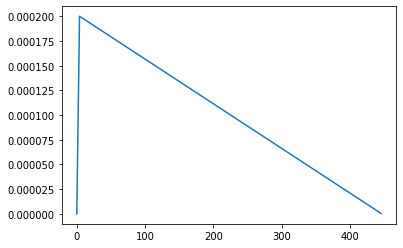

In [71]:
def lr_for_step(step: int, max_step: int, max_lr: float, warmup_step_frac: float):
    '''
    The authors used learning rate warmup from an unspecified value and an unspecified shape to a maximum of 1e-4 for the first 10,000 steps out of 1 million, and then linearly decayed to an unspecified value.

    From the repo, we can see in optimization.py that AdamW is used for the optimizer, that the warmup is linear and that the epsilon used for AdamW is 1e-6.

    Assume that the initial learning rate and the final learning rate are both 1/10th of the maximum, and that we want to warm-up for 1% of the total number of steps.
    Return the learning rate for use at this step of training.'''
    warmup_steps = int(max_step * warmup_step_frac)
    if step < warmup_steps:
        return max_lr * step / warmup_steps
    else:
        return max_lr * (max_step - step) / (max_step - warmup_steps)


if MAIN:
    max_step = int(len(train_loader) * config_dict["epochs"])
    lrs = [
        lr_for_step(step, max_step, max_lr=config_dict["lr"], warmup_step_frac=config_dict["warmup_step_frac"])
        for step in range(max_step)
    ]
    plt.plot(lrs)

In [82]:
def bert_mlm_pretrain(model: BertLanguageModel, config_dict: dict, train_loader: DataLoader) -> None:
    '''Train using masked language modelling.'''
    model.train()
    model.to(device)
    opt = make_optimizer(model, config_dict)
    wandb.init(project="bert", config=config_dict)
    wandb.watch(model)
    run_name = wandb.run.name
    # tqdm progress bar of train loader annotated with epoch number
    os.makedirs(f"models/{run_name}")
    t.save(model.state_dict(), f"./models/{run_name}/epoch_-1.pt")
    
    for epoch in range(config_dict['epochs']):
        train_loader = tqdm(train_loader, desc=f"Epoch {epoch}")
        for n_batch, (batch,) in enumerate(train_loader):
            wandb.log({"epoch": epoch, "batch": n_batch})
            batch = batch.to(device)
            opt.zero_grad()
            lr = lr_for_step(
                n_batch + epoch * len(train_loader),
                max_step=int(len(train_loader) * config_dict["epochs"]),
                max_lr=config_dict["lr"],
                warmup_step_frac=config_dict["warmup_step_frac"],
            )
            opt.lr = lr
            masked_input_ids, mask = random_mask(batch, tokenizer.mask_token_id, tokenizer.vocab_size)
            masked_input_ids = masked_input_ids.to(device)
            mask = mask.to(device)
            logits = model(masked_input_ids, mask, token_type_ids=None)
            loss = cross_entropy_selected(logits, batch, mask)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            wandb.log({"loss": loss, "lr": lr})
            opt.step()
        t.save(model.state_dict(), f"./models/{run_name}/epoch_{epoch}.pt")
    wandb.finish()

if MAIN:
    tiny_bert = BertLanguageModel(bert_config_tiny)
    num_params = sum((p.nelement() for p in tiny_bert.parameters()))
    print("Number of model parameters: ", num_params)
    bert_mlm_pretrain(tiny_bert, config_dict, train_loader)

Number of model parameters:  40425284


Problem at: <ipython-input-82-5439a9e04f9f> 6 bert_mlm_pretrain


KeyboardInterrupt: 